# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays
import pickle

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, MAE, RMSE

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.tune.progress_reporter import JupyterNotebookReporter


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv(
    "../0_data/preprocessed/df_final_reduced.csv", try_parse_dates=True
).filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001


In [3]:
df.shape

(26304, 4)

In [4]:
df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001


# Missing values

Just forward fill for now.

In [5]:
df = df.fill_null(strategy="forward")

# Calendar Features

In [6]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    month=pl.col("datetime").dt.month(),
    hour=pl.col("datetime").dt.hour(),
    year=pl.col("datetime").dt.year(),
)

# Holidays

In [7]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

In [8]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df.head()

holiday_name,holiday_date
str,date
"""Neujahrestag""",2021-01-01
"""Berchtoldstag""",2021-01-02
"""Karfreitag""",2021-04-02
"""Ostermontag""",2021-04-05
"""Tag der Arbeit""",2021-05-01


In [9]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
    .with_columns(holiday_name=pl.col("holiday_name").fill_null("no_holiday"))
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,day_of_month,day_of_year,day_of_week,month,hour,year,holiday_name
datetime[μs],f64,f64,f64,i8,i16,i8,i8,i8,i32,str
2021-09-01 00:00:00,5.1633e6,0.0,16.042,1,244,3,9,0,2021,"""no_holiday"""
2021-09-01 01:00:00,5.0777e6,0.0,15.892,1,244,3,9,1,2021,"""no_holiday"""
2021-09-01 02:00:00,4.9315e6,0.0,16.042,1,244,3,9,2,2021,"""no_holiday"""
2021-09-01 03:00:00,4.7878e6,0.0,15.942,1,244,3,9,3,2021,"""no_holiday"""
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,1,244,3,9,4,2021,"""no_holiday"""


# Column naming convention stipulated by neuralforecast

- ds: datetime column with timestamps
- unique_id: for multivariate forecasting use different string values, for univariate, use one
- y: target variable
- include exogenous predictors as columns to the right

In [10]:
df = df.rename({"datetime": "ds", "kWh": "y"}).with_columns(unique_id=pl.lit("kWh"))

df.head()

ds,y,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,day_of_month,day_of_year,day_of_week,month,hour,year,holiday_name,unique_id
datetime[μs],f64,f64,f64,i8,i16,i8,i8,i8,i32,str,str
2021-09-01 00:00:00,5.1633e6,0.0,16.042,1,244,3,9,0,2021,"""no_holiday""","""kWh"""
2021-09-01 01:00:00,5.0777e6,0.0,15.892,1,244,3,9,1,2021,"""no_holiday""","""kWh"""
2021-09-01 02:00:00,4.9315e6,0.0,16.042,1,244,3,9,2,2021,"""no_holiday""","""kWh"""
2021-09-01 03:00:00,4.7878e6,0.0,15.942,1,244,3,9,3,2021,"""no_holiday""","""kWh"""
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,1,244,3,9,4,2021,"""no_holiday""","""kWh"""


In [11]:
df = pl.concat(
    [df.select(["unique_id", "ds", "y"]), df.drop(["ds", "unique_id", "y"])],
    how="horizontal",
)

df.head()

unique_id,ds,y,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,day_of_month,day_of_year,day_of_week,month,hour,year,holiday_name
str,datetime[μs],f64,f64,f64,i8,i16,i8,i8,i8,i32,str
"""kWh""",2021-09-01 00:00:00,5.1633e6,0.0,16.042,1,244,3,9,0,2021,"""no_holiday"""
"""kWh""",2021-09-01 01:00:00,5.0777e6,0.0,15.892,1,244,3,9,1,2021,"""no_holiday"""
"""kWh""",2021-09-01 02:00:00,4.9315e6,0.0,16.042,1,244,3,9,2,2021,"""no_holiday"""
"""kWh""",2021-09-01 03:00:00,4.7878e6,0.0,15.942,1,244,3,9,3,2021,"""no_holiday"""
"""kWh""",2021-09-01 04:00:00,4.7038e6,0.0,15.792001,1,244,3,9,4,2021,"""no_holiday"""


# Cyclical Encoding

In [12]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [13]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    "day_of_week": 7,
    "month": 12,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [14]:
cat_cols = ["holiday_name"]

num_cols = df.select(
    cs.contains(
        "soil_temperature_7_to_28cm",
        "shortwave_radiation",
    )
).columns + ["year"]

manual_cols = df.select(pl.selectors.contains("_cos", "_sin", "is_")).columns + [
    "unique_id",
]

In [15]:
df.drop(manual_cols + cat_cols + num_cols)

ds,y
datetime[μs],f64
2021-09-01 00:00:00,5.1633e6
2021-09-01 01:00:00,5.0777e6
2021-09-01 02:00:00,4.9315e6
2021-09-01 03:00:00,4.7878e6
2021-09-01 04:00:00,4.7038e6
…,…
2024-08-31 19:00:00,5.3614e6
2024-08-31 20:00:00,5.3775e6
2024-08-31 21:00:00,5.2130e6


In [16]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [17]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [18]:
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

In [19]:
preprocessor = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        (
            "variance_threshold",
            VarianceThreshold(threshold=0.0),
        ),  # Drops constant columns after transformations
    ]
)

# Hyperparameter Tuning

## Creating Splits and Full Dataframe

`NBEATSx.fit (dataset, val_size=0, test_size=0, random_seed=None, distributed_config=None)`

Need to keep everything in a single `dataset`, then specify validation and test size in the fit call.


In [20]:
df_train = df.filter(
    (pl.col("ds") >= pl.datetime(year=2021, month=9, day=1, hour=0))
    & (pl.col("ds") <= pl.datetime(year=2022, month=8, day=31, hour=23))
).to_pandas()

df_val = df.filter(
    (pl.col("ds") >= pl.datetime(year=2022, month=9, day=1, hour=0))
    & (pl.col("ds") <= pl.datetime(year=2023, month=8, day=31, hour=23))
).to_pandas()

df_test = df.filter(
    pl.col("ds") >= pl.datetime(year=2023, month=9, day=1, hour=0)
).to_pandas()

df_trainval = pd.concat([df_train, df_val], axis=0)

In [21]:
X_train = df_train.drop(columns=["unique_id", "ds", "y"])
X_val = df_val.drop(columns=["unique_id", "ds", "y"])
X_test = df_test.drop(columns=["unique_id", "ds", "y"])

X_trainval = df_trainval.drop(columns=["unique_id", "ds", "y"])

In [22]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

In [23]:
fitted_preprocessor = preprocessor.fit(X_trainval)

X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out(),
)

In [24]:
df_train_preprocessed = pd.concat(
    [df_train.filter(["unique_id", "ds", "y"]), X_train_preprocessed], axis=1
)

df_val_preprocessed = pd.concat(
    [df_val.filter(["unique_id", "ds", "y"]), X_val_preprocessed], axis=1
)

df_test_preprocessed = pd.concat(
    [df_test.filter(["unique_id", "ds", "y"]), X_test_preprocessed], axis=1
)

In [25]:
df_full_preprocessed = pd.concat(
    [df_train_preprocessed, df_val_preprocessed, df_test_preprocessed], axis=0
).reset_index(drop=True)

In [26]:
(df_full_preprocessed["ds"] - df_full_preprocessed["ds"].shift(1)).value_counts()

ds
0 days 01:00:00    26303
Name: count, dtype: int64

## Manual test

Non-tuneable parameters:

- **h**: int, Forecast horizon.
- **stat_exog_list**: `List[str]`, Static exogenous columns.
- **hist_exog_list**: `List[str]`, Historic exogenous columns.
- **futr_exog_list**: `List[str]`, Future exogenous columns.
- **exclude_insample_y**: `bool=False`, The model skips the autoregressive features `y[t-input_size:t]` if True.
- **windows_batch_size**: `int=1024`, Number of windows to sample in each training batch; default uses all.
- **inference_windows_batch_size**: `int=-1`, Number of windows to sample in each inference batch; `-1` uses all.
- **start_padding_enabled**: `bool=False`, If True, the model will pad the time series with zeros at the beginning by `input_size`.
- **step_size**: `int=1`, Step size between each window of temporal data.
- **random_seed**: int, Random seed initialization for replicability.
- **drop_last_loader**: `bool=False`, If True, `TimeSeriesDataLoader` drops the last non-full batch.
- **num_workers_loader**: `int=os.cpu_count()`, Workers to be used by `TimeSeriesDataLoader`.
- **alias**: str, optional, Custom name of the model.
- **trainer_kwargs**: int, Keyword trainer arguments inherited from PyTorch Lightning’s trainer.
- **loss**: PyTorch module, Instantiated train loss class from the losses collection.
- **valid_loss**: `PyTorch module=loss`, Instantiated valid loss class from the losses collection.
- **max_steps**: `int=1000`, Maximum number of training steps.
- **scaler_type**: `str=identity`, Type of scaler for temporal input normalization; see temporal scalers.

Tuneable parameters:

- **input_size**: int, Autoregressive input size, e.g., if `y = [1, 2, 3, 4]` and `input_size = 2`, then `y[t-2:t] = [1, 2]`.
- **n_harmonics**: int, Number of harmonic oscillations in the SeasonalityBasis `[cos(i * t / n_harmonics), sin(i * t / n_harmonics)]`. Note that it will only be used if `seasonality` is in `stack_types`.
- **n_polynomials**: int, Number of polynomial terms for TrendBasis `[1, t, …, t^n_poly]`. Note that it will only be used if `trend` is in `stack_types`.
- **stack_types**: `List[str]`, List of stack types. Subset from `[seasonality, trend, identity]`.
- **n_blocks**: `List[int]`, Number of blocks for each stack. Note that `len(n_blocks) = len(stack_types)`.
- **mlp_units**: `List[List[int]]`, Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that `len(n_hidden) = len(stack_types). MLP units for each stack type, factor 3 needs to stay if 3 stack types are used
- **dropout_prob_theta**: float, Float between (0, 1). Dropout for N-BEATS basis.
- **activation**: str, Activation function from `[ReLU, Softplus, Tanh, SELU, LeakyReLU, PReLU, Sigmoid]`.
- **learning_rate**: `float=1e-3`, Learning rate between (0, 1).
- **num_lr_decays**: int, Number of learning rate decays, evenly distributed across `max_steps`.
- **early_stop_patience_steps**: `int=-1`, Number of validation iterations before early stopping.
- **val_check_steps**: `int=100`, Number of training steps between every validation loss check.
- **batch_size**: `int=32`, Number of different series in each batch.
- **valid_batch_size**: `int=None`, Number of different series in each validation and test batch; if None, uses `batch_size`.
- **optimizer**: Subclass of `torch.optim.Optimizer`, optional, User-specified optimizer instead of the default choice (Adam).
- **optimizer_kwargs**: dict, optional, List of parameters used by the user-specified optimizer.
- **lr_scheduler**: Subclass of `torch.optim.lr_scheduler.LRScheduler`, optional, User-specified learning rate scheduler instead of the default choice (StepLR).
- **lr_scheduler_kwargs**: dict, optional, List of parameters used by the user-specified learning rate scheduler.


In [ ]:
horizon = 24
historical_horizon = 7 * horizon

model = NBEATSx(
    # Non-tuneable
    h=horizon,
    input_size=historical_horizon,
    step_size=horizon,
    futr_exog_list=df_full_preprocessed.drop(columns=["ds", "y", "unique_id"]).columns,
    loss=RMSE(),
    valid_loss=RMSE(),
    val_check_steps=1,
    max_steps=2000,
    scaler_type="identity",
    # Tuneable
    n_harmonics=2,
    n_polynomials=5,
    stack_types=["identity", "trend", "seasonality"],
    n_blocks=[1, 1, 1],
    mlp_units=3 * [3 * [8]],
    dropout_prob_theta=0.1,
    activation="LeakyReLU",
    learning_rate=0.01,
    num_lr_decays=5,
    early_stop_patience_steps=50,
    batch_size=64,
)

forecaster = NeuralForecast(models=[model], freq="h")
holdout_preds = forecaster.cross_validation(
    df=df_full_preprocessed,
    n_windows=None,
    val_size=df_val_preprocessed.shape[0],
    test_size=df_test_preprocessed.shape[0],
    step_size=horizon,
)

Visualise validation predictions:

In [28]:
val_preds = forecaster.predict_insample(step_size=24).tail(-historical_horizon)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.


In [29]:
loss = root_mean_squared_error(y_pred=val_preds["NBEATSx"], y_true=val_preds["y"])
loss

317662.8

In [30]:
fig = px.line(
    val_preds,
    x="ds",
    y=["NBEATSx", "y"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

fig.show()

## RayTune Tuning Loop

In [ ]:
def nbeatsx_trainable(config):

    try:

        model = NBEATSx(
            # Non-tuneable
            h=config["h"],
            input_size=config["input_size"],
            step_size=config["step_size"],
            futr_exog_list=df_full_preprocessed.drop(
                columns=["ds", "y", "unique_id"]
            ).columns,
            loss=RMSE(),
            valid_loss=RMSE(),
            val_check_steps=config["val_check_steps"],
            max_steps=config["max_steps"],
            scaler_type=config["scaler_type"],
            # Tuneable
            n_harmonics=config["n_harmonics"],
            n_polynomials=config["n_polynomials"],
            stack_types=config["stack_types"],
            n_blocks=[
                config["n_blocks_seasonality"],
                config["n_blocks_trend"],
                config["n_blocks_identity"],
            ],
            mlp_units=3 * [config["n_hidden"] * [config["hidden_size"]]],
            dropout_prob_theta=config["dropout_prob_theta"],
            activation=config["activation"],
            learning_rate=config["learning_rate"],
            num_lr_decays=config["num_lr_decays"],
            early_stop_patience_steps=config["early_stop_patience_steps"],
            batch_size=config["batch_size"],
        )

        forecaster = NeuralForecast(models=[model], freq="h")
        holdout_preds = forecaster.cross_validation(
            df=df_full_preprocessed,
            n_windows=None,
            val_size=df_val_preprocessed.shape[0],
            test_size=df_test_preprocessed.shape[0],
            step_size=config["h"],
        )

        # Validation loss
        val_preds = forecaster.predict_insample(step_size=config["h"]).tail(
            df_val_preprocessed.shape[0]
        )
        loss = root_mean_squared_error(
            y_pred=val_preds["NBEATSx"], y_true=val_preds["y"]
        )
        train.report({"loss": loss})

    except Exception as e:
        train.report({"loss": float("inf")})

In [ ]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    nbeatsx_trainable,
    config={
        # Non-tuneable
        "h": 24,
        "step_size": 24,
        "val_check_steps": 1,
        "max_steps": 2000,
        "scaler_type": "identity",
        # Tuneable
        "input_size": tune.choice([24 * x for x in range(1, 7 + 1)]),
        "n_harmonics": tune.randint(1, 10 + 1),
        "n_polynomials": tune.randint(1, 10 + 1),
        "stack_types": ["seasonality", "trend", "identity"],
        "n_blocks_seasonality": tune.randint(1, 3 + 1),
        "n_blocks_trend": tune.randint(1, 3 + 1),
        "n_blocks_identity": tune.randint(1, 3 + 1),
        "n_hidden": tune.randint(1, 6 + 1),
        "hidden_size": tune.choice([8, 16, 32, 64, 128, 256, 512]),
        "dropout_prob_theta": tune.uniform(0.0, 0.5),
        "activation": tune.choice(["ReLU", "Tanh", "LeakyReLU", "Sigmoid"]),
        "learning_rate": tune.loguniform(1e-5, 1e-2),
        "num_lr_decays": tune.randint(0, 10 + 1),  # Learning rate decay events
        "early_stop_patience_steps": tune.choice([25, 50, 100, 250]),
        "batch_size": tune.choice([16, 32, 64, 128, 256]),
    },
    metric="loss",
    mode="min",
    name="NBEATSx",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 20,
    num_samples=-1,
    max_concurrent_trials=8,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

In [29]:
analysis.dataframe().to_csv("4_NBEATSX_trials.csv", index=False)

# Validation Performance of the Best Model

In [27]:
trials_df = pl.read_csv("4_NBEATSX_trials.csv")

In [90]:
trials_df.shape[0]

689

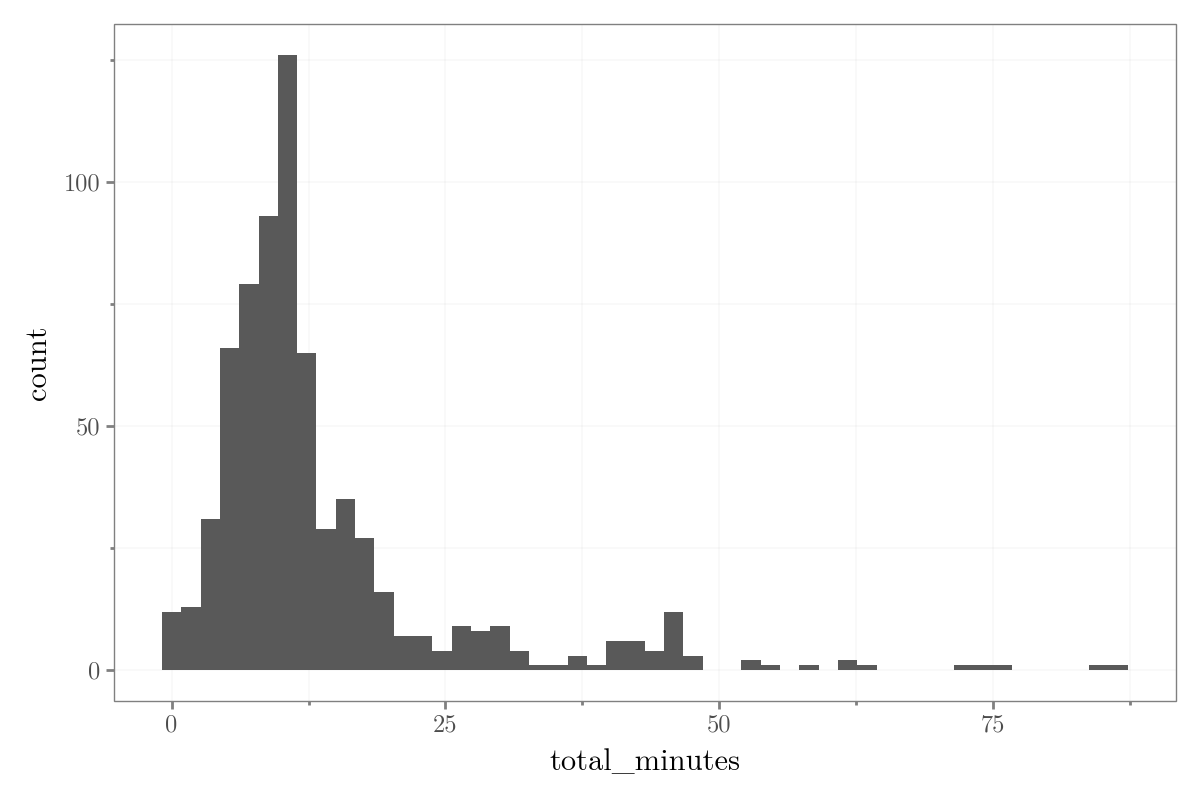

In [28]:
(
    pn.ggplot(
        data=(trials_df.with_columns(total_minutes=pl.col("time_total_s") / 60)),
        mapping=pn.aes("total_minutes"),
    )
    + pn.geom_histogram(bins=50)
    + theme_academic
)

Training time vs performance:

In [91]:
# Read best combination from data frame
best_hyperparams_df = (
    pl.read_csv("4_NBEATSX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .drop("config/futr_exog_list", "config/loss", "config/valid_loss")
    .unpivot()
    .with_columns(pl.col("variable").str.replace("config/", ""))
)

# Make dictionary (all strings)
best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

# Convert strings to correct data types
converted_params = {
    "h": int(best_hyperparams["h"]),
    "step_size": int(best_hyperparams["step_size"]),
    "val_check_steps": int(best_hyperparams["val_check_steps"]),
    "max_steps": int(best_hyperparams["max_steps"]),
    "scaler_type": best_hyperparams["scaler_type"],
    "input_size": int(best_hyperparams["input_size"]),
    "n_harmonics": int(best_hyperparams["n_harmonics"]),
    "n_polynomials": int(best_hyperparams["n_polynomials"]),
    "stack_types": eval(
        best_hyperparams["stack_types"]
    ),  # Convert string list to actual list
    "n_blocks": [
        int(best_hyperparams["n_blocks_seasonality"]),
        int(best_hyperparams["n_blocks_trend"]),
        int(best_hyperparams["n_blocks_identity"]),
    ],
    "mlp_units": int(best_hyperparams["n_hidden"])
    * [int(best_hyperparams["n_hidden"]) * [int(best_hyperparams["hidden_size"])]],
    "dropout_prob_theta": float(best_hyperparams["dropout_prob_theta"]),
    "activation": best_hyperparams["activation"],
    "learning_rate": float(best_hyperparams["learning_rate"]),
    "num_lr_decays": int(best_hyperparams["num_lr_decays"]),
    "early_stop_patience_steps": int(best_hyperparams["early_stop_patience_steps"]),
    "batch_size": int(best_hyperparams["batch_size"]),
}

converted_params

{'h': 24,
 'step_size': 24,
 'val_check_steps': 1,
 'max_steps': 2000,
 'scaler_type': 'identity',
 'input_size': 168,
 'n_harmonics': 4,
 'n_polynomials': 4,
 'stack_types': ['seasonality', 'trend', 'identity'],
 'n_blocks': [2, 3, 3],
 'mlp_units': [[128, 128, 128], [128, 128, 128], [128, 128, 128]],
 'dropout_prob_theta': 0.11022215986101364,
 'activation': 'ReLU',
 'learning_rate': 0.005072872672063009,
 'num_lr_decays': 3,
 'early_stop_patience_steps': 250,
 'batch_size': 128}

In [ ]:
model = NBEATSx(
    # Non-tuneable
    h=converted_params["h"],
    input_size=converted_params["input_size"],
    step_size=converted_params["step_size"],
    futr_exog_list=df_full_preprocessed.drop(columns=["ds", "y", "unique_id"]).columns,
    loss=RMSE(),
    valid_loss=RMSE(),
    val_check_steps=converted_params["val_check_steps"],
    max_steps=converted_params["max_steps"],
    scaler_type=converted_params["scaler_type"],
    # Tuneable
    n_harmonics=converted_params["n_harmonics"],
    n_polynomials=converted_params["n_polynomials"],
    stack_types=converted_params["stack_types"],
    n_blocks=converted_params["n_blocks"],
    mlp_units=converted_params["mlp_units"],
    dropout_prob_theta=converted_params["dropout_prob_theta"],
    activation=converted_params["activation"],
    learning_rate=converted_params["learning_rate"],
    num_lr_decays=converted_params["num_lr_decays"],
    early_stop_patience_steps=converted_params["early_stop_patience_steps"],
    batch_size=converted_params["batch_size"],
)

# Initialize and run cross-validation
forecaster = NeuralForecast(models=[model], freq="h")
holdout_preds = forecaster.cross_validation(
    df=df_full_preprocessed,
    n_windows=None,
    val_size=df_val_preprocessed.shape[0],
    test_size=df_test_preprocessed.shape[0],
    step_size=converted_params["h"],
)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | valid_loss   | RMSE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.4 M  | train
-------------------------------------------------------
5.4 M     Trainable params
37.4 K    Non-trainable params
5.4 M     Total params
21.800    Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.


Visualise validation predictions:

In [80]:
val_preds = forecaster.predict_insample(step_size=24).tail(df_val_preprocessed.shape[0])

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\neuralforecast\core.py:210: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [81]:
loss = root_mean_squared_error(y_pred=val_preds["NBEATSx"], y_true=val_preds["y"])
loss

242159.75

In [82]:
fig = px.line(
    val_preds,
    x="ds",
    y=["NBEATSx", "y"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

fig.show()

# Model Evaluation without Retraining

Evaluate on the holdout period by retraining with the best best_hyperparams chosen from the holdout evaluation

In [83]:
y_preds_holdout = (
    holdout_preds.reset_index()
    .rename(columns={"ds": "datetime", "NBEATSx": "pred", "y": "kWh"})
    .filter(["datetime", "pred", "kWh"])
)

y_preds_holdout.head()

,datetime,pred,kWh
0,2023-09-01 00:00:00,4948421.5,4.952079e+06
1,2023-09-01 01:00:00,4811462.0,4.789383e+06
2,2023-09-01 02:00:00,4702511.0,4.689283e+06
3,2023-09-01 03:00:00,4565082.5,4.490485e+06
4,2023-09-01 04:00:00,4435964.5,4.345052e+06


In [ ]:
y_preds_holdout.to_csv("4_NBEATSX_holdout_predictions_no_retraining.csv", index=False)

In [85]:
loss = root_mean_squared_error(
    y_pred=holdout_preds["NBEATSx"], y_true=holdout_preds["y"]
)
loss

328113.1257741727

In [86]:
fig = px.line(
    holdout_preds,
    x="ds",
    y=["NBEATSx", "y"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

fig.show()

# Model Evaluation with Retraining

Evaluate on the holdout period by retraining with the best best_hyperparams chosen from the holdout evaluation

# Interpretable Configuration